In [1]:
import torch
from torch.utils.data import DataLoader, Dataset
from torch import nn
from torch.nn import functional as F

import json
import re

import numpy as np
import itertools
from collections import Counter, defaultdict

from tqdm import tqdm_notebook


import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# !pip3 install pymorphy2[fast]
# !pip3 install gensim
# !pip3 install torchtext
# !pip3 install emoji


In [3]:
import pymorphy2

morph = pymorphy2.MorphAnalyzer()

def normal_form(word):
    return morph.parse(word)[0].normal_form

In [4]:
import emoji

def find_emoji(text):
    emojis = []
    for character in text:
        if character in emoji.UNICODE_EMOJI:
            emojis.append(character)
    return emojis

def char_is_emoji(character):
    return character in emoji.UNICODE_EMOJI


In [5]:
def preprocess(text):
    return ' '.join([normal_form(i) for i in re.findall(r'[А-я]+', text) if len(i) > 2])

In [6]:
import torchtext.vocab as vocab

vectors = vocab.Vectors('../data/ruwiki_20180420_100d.txt') # file created by gensim


In [7]:
PAD_IDX = len(vectors.stoi) - 2
UNK_IDX = len(vectors.stoi) - 1
TOTAL_EMBS = len(vectors)

In [8]:
def vectorize(text):
    emojis = find_emoji(text['text'])
    if len(emojis) == 0:
        return None, None
    try:
        text = preprocess(text['text'])
    except TypeError as e:
        return None, None
    inds = []
    if len(text.split()) < 3:
        return None, None
    for word in text.split():
        try:
            inds.append(vectors.stoi[word])
        except KeyError:
            inds.append(UNK_IDX)
    if len(inds) < 2:
        return None, None
    while len(inds) < 90:
        inds.append(PAD_IDX)
    return inds[:90], emojis

In [9]:
def vectorize_all(texts):
    ans = []
    emojis = []
    for text in tqdm_notebook(texts):
        try:
            vec, ems = vectorize(text)
        except Exception as e:
            continue
        if vec:
            ans.append(vec)
            emojis.append(ems)
    return ans, emojis

In [10]:
with open('../data/mem_big.json', 'r') as f:
    cosmo = json.load(f)
cosmo, emojis = vectorize_all(cosmo)


In [11]:
# e2num = Counter(itertools.chain.from_iterable(emojis))
# e2i = defaultdict(lambda:632)
# c = 0
# for ind, e in enumerate(e2num):
#     if e2num[e[0]] > 3:
#         e2i[e[0]] = c
#         c+=1
#     else:
#         print(e, end=' ')

# i2e = defaultdict(lambda:'❓')
# for e, i in e2i.items():
#     i2e[i] = e


In [12]:
e2num = Counter(itertools.chain.from_iterable(emojis))
e2i = {}
c = 0
for ind, e in enumerate(e2num):
    if e2num[e[0]] > 3:
        e2i[e[0]] = c
        c+=1
    else:
        print(e, end=' ')

i2e = {}
for e, i in e2i.items():
    i2e[i] = e


🐼 🚃 😗 📐 🏈 🛥 😚 🌨 🎷 🤫 ➰ 🌧 🔫 🛫 😵 🔎 🚒 🐋 🥦 🏥 🌦 🧣 🇵 🎮 🖥 🛋 🔦 😣 🍡 🐒 📈 👡 🍥 🙉 🥘 💲 🐈 ☄ 🐦 🛀 🗓 🌫 🍮 🏚 🌽 😒 📡 🎿 📕 😐 🏫 🐏 🏔 ⚗ 🔔 🇳 📆 🚶 🎣 🚿 🔖 👮 🚲 ↖ ⚜ 🎏 📅 🥈 📞 🕶 🕑 🌜 🐥 🏪 🌇 😽 ™ 🎎 🏛 ⚓ 🚫 📑 📊 🇩 🥉 🚁 🧜 👕 🌵 😷 🤖 🏓 👬 😴 🎠 📣 💯 👅 👾 🏦 🤳 🛩 📵 🤒 👿 😡 🌮 🌪 🐝 🇿 😪 🐤 🌯 🎆 ↔ 📋 🍨 🍷 🦸 😑 🐠 🧁 😟 🐭 🎓 ✋ 😸 🖊 🐩 🏰 🧗 😰 🤙 🥬 🐷 🌒 💶 🎢 🍱 🧸 🕚 🚇 📦 ⛑ 🤨 🇲 👐 🥒 🚉 🧒 🗣 🖋 🍅 🐔 ⛵ 🧥 🏝 🍚 🤢 📻 🦃 🤼 🏀 📄 🐅 👣 📨 🌻 👃 😩 🌔 ⛔ 💼 🖐 🔒 😦 🖖 🎫 🎺 🛌 🚑 🚖 🚡 ☃ 🎟 🧵 🚂 🍖 🥙 🚤 ⚪ ⬇ 🍽 🍴 🐸 🙁 🧟 🎰 📜 🤝 🌥 🌛 🏌 💒 ♠ 🗞 🌐 🏨 🚊 ☹ 🚐 🛰 👂 🐄 💿 📮 ⛪ 😫 🍐 🧀 🇦 🏹 ⏸ 🚔 🌕 👛 🦇 🤑 🐍 🚘 💧 🔳 🐯 🌁 ➕ ⚾ 🚼 😨 🕛 ⛳ 🐑 🧐 🤞 🥪 🚓 🍵 🐿 🍇 🎖 🛳 🔵 🐇 🤺 🖼 💉 🔅 🇰 📀 📒 🇯 🍤 🌱 🙆 🎇 🔊 🥤 ⏱ 🚢 ✏ 👹 😿 ✉ ⌛ ☁ 🚵 🏠 ⌚ 🚌 ✒ 🐘 🌾 🥚 🐀 ⛹ 👞 🚦 🎻 📔 🦅 👊 🦎 🚨 🙇 🎡 ⚖ 🧝 📬 🎪 💽 🌌 ⚔ 🇨 🍜 😺 🌳 🍆 🛷 🇬 🕰 🔬 👴 

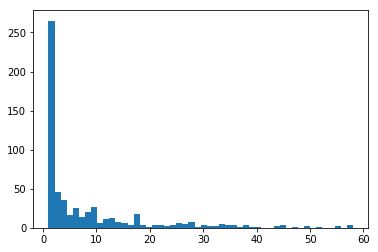

In [13]:
plt.hist([i[1] for i in e2num.most_common() if i[1] < 60], bins=50)
plt.show()

In [14]:
class FasttextSet(Dataset):
    def __init__(self, cosmo):
        '''
        data - json file name
        '''
        with open(cosmo, 'r') as f:
            self.cosmo = json.load(f)
        self.cosmo, self.emojis = vectorize_all(self.cosmo)
        self.cosmo = np.array(self.cosmo)
        
        self.x = []
        self.y = []
        for vec, em in zip(self.cosmo, self.emojis):
            emjs = np.zeros(len(e2i))
            empty_flag = 0
            for e in em:
                try:
                    emjs[e2i[e]] = 1
                    empty_flag = 1
                except Exception as e:
                    continue
            if empty_flag:
                self.x.append(vec)
                self.y.append(emjs)
        self.x = np.row_stack(self.x)
        self.y = np.row_stack(self.y)
            
    def __len__(self):
        return len(self.x)
    
    def __getitem__(self, ind):
        return torch.Tensor(self.x[ind]).long(), self.y[ind]

In [15]:
memLoader = DataLoader(FasttextSet('../data/mem-train.json'),
                       batch_size=32, shuffle=True)

In [17]:
memLoader_val = DataLoader(FasttextSet('../data/mem-val.json'),
                           batch_size=32, shuffle=True)

In [18]:
class SimilarityNet(nn.Module):
    def __init__(self, ):
        super(SimilarityNet, self).__init__()
        self.embs = nn.Embedding(len(vectors), embedding_dim=100, padding_idx=PAD_IDX).from_pretrained(
            torch.FloatTensor(vectors.vectors)
        )
        self.process = nn.Sequential(
            nn.Conv1d(100, 128, 15),
            nn.BatchNorm1d(128),
            nn.LeakyReLU(0.05),
            nn.Conv1d(128, 128, 9),
            nn.BatchNorm1d(128),
            nn.LeakyReLU(0.05),
            nn.Conv1d(128, 32, 5),
            nn.BatchNorm1d(32),
            nn.LeakyReLU(0.05),
        )
        self.fc = nn.Sequential(
            nn.Linear(2048, 1024),
            nn.BatchNorm1d(1024),
            nn.ReLU(),
            nn.Linear(1024, len(e2i)),
            nn.BatchNorm1d(len(e2i)),
#            nn.Sigmoid(),
            
        )
        
    def forward(self, x):
        x = self.process(self.embs(x).permute(0, 2, 1))
        x = x.view(x.shape[0], -1)
        return self.fc(x)

In [19]:
simnet = SimilarityNet().cuda()
criterion = nn.BCEWithLogitsLoss()
optim = torch.optim.Adam(simnet.parameters())

In [20]:
train_losses = []

for epoch in tqdm_notebook(range(100)):
    for x, target in tqdm_notebook(memLoader, leave=False):
        x, target = x.cuda(), target.cuda()
        optim.zero_grad()
        pred = simnet(x)
        loss = criterion(pred, target.float())
        train_losses.append(loss.item())
        loss.backward()
        optim.step()


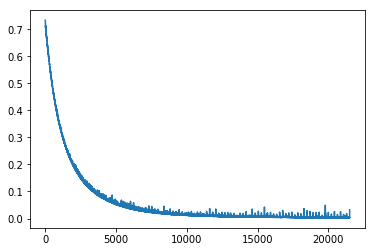

In [21]:
plt.plot(train_losses)

In [26]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))


y_true = []
y_pred = []

for x, target in tqdm_notebook(memLoader_val):
    pred = simnet(x.cuda())
    for i, j in zip(pred.cpu().squeeze().detach().numpy(), target.detach().numpy()):
        y_pred.append(sigmoid(i))
        y_true.append(j)

y_true = np.row_stack(y_true)
y_pred = np.row_stack(y_pred)


In [27]:
y_pred.shape

(73, 359)

In [33]:
y_predictions = np.argsort(y_pred)[:, -3::]
y_true_h = np.argsort(y_true)[:, -2::]

In [34]:
y_predictions.shape

(73, 3)

In [36]:
for pred, true in zip(y_predictions, y_true_h):
    print('pred -> ', ' '.join([i2e[p] for p in pred]), '\t true -> ', ' '.join([i2e[t] for t in true]))

pred ->  ✨ 🎉 😍 	 true ->  🐕 ©
pred ->  ♀ 🙈 🍓 	 true ->  🙋 🏽
pred ->  ❗ ⚡ ✨ 	 true ->  ⚡ ❄
pred ->  👀 📷 😍 	 true ->  🐕 📷
pred ->  📷 💫 😉 	 true ->  🐕 😉
pred ->  ☝ 💞 🏼 	 true ->  🤔 🍳
pred ->  👆 🏼 ❤ 	 true ->  🐕 💄
pred ->  ❤ 🏼 😍 	 true ->  🐕 😉
pred ->  ♎ ♊ ♏ 	 true ->  📸 ♎
pred ->  👼 💐 🎉 	 true ->  🐕 😍
pred ->  💖 ❤ 🎉 	 true ->  🎊 ❤
pred ->  ✨ 😏 ❤ 	 true ->  🏼 🎬
pred ->  👇 😏 💫 	 true ->  🍒 ❤
pred ->  ♑ ♌ ♓ 	 true ->  ♋ ♉
pred ->  💕 💋 😉 	 true ->  🐬 🌞
pred ->  💋 👌 😍 	 true ->  😍 👀
pred ->  🏼 🏽 ✨ 	 true ->  🎤 ✨
pred ->  💫 🏻 😍 	 true ->  ✅ 🙀
pred ->  👩 😍 💫 	 true ->  🌴 🔥
pred ->  🎬 ❤ 🏻 	 true ->  🎤 💃
pred ->  ♊ ♈ 😉 	 true ->  ♋ ♎
pred ->  👼 😍 💫 	 true ->  ✔ ✨
pred ->  ✨ 👏 🎉 	 true ->  💫 🎉
pred ->  ♥ 👯 ✨ 	 true ->  🐕 💟
pred ->  👼 🎥 🔥 	 true ->  🐕 📹
pred ->  🍭 🌞 🔥 	 true ->  😍 ☀
pred ->  📷 💫 😉 	 true ->  🐕 😉
pred ->  ♒ ♓ ♏ 	 true ->  ♒ ♎
pred ->  💫 🏻 💥 	 true ->  💙 👇
pred ->  ♎ ♈ ♊ 	 true ->  ♒ ♎
pred ->  📷 🎂 ❤ 	 true ->  ♋ ♎
pred ->  ♋ ♌ ♐ 	 true ->  ♒ ♉
pred ->  💋 ❤ ✨ 	 true ->  ✨ ❤
pred ->  ❤

In [27]:
np.argsort(y_pred[0])

array([230,   2,  97, 237, 130,  75, 257, 319,  56, 216, 172, 282, 139,
        83, 318, 310, 179, 141, 285, 281,  67,  22, 247, 159, 154, 238,
        91,  11,  87,  12, 278, 224, 111,  40,  74,  39,  71,  63, 299,
       212, 265, 279, 314, 229,  20, 231, 327, 166, 357, 334, 217, 330,
       236, 321, 145, 101, 226,  85, 100,   4, 174, 133, 343, 132,  25,
       316, 322, 180, 223,  73, 193, 164,  59, 254,   9, 277,  19, 135,
       211,   0, 143, 349, 204,  72, 213, 274, 276, 233, 308,  98,  61,
       188,  78, 271, 335, 156, 113,  29, 272, 358, 157, 256, 328, 291,
       292, 326, 131, 350, 161, 347, 186, 239, 144, 169, 246,  30, 263,
        15,  32, 258,  65, 235, 313,  54,   8,  58, 250, 251, 191, 151,
       162,  37,  36, 283,   7,  88,  44, 297, 110, 167, 128, 125,  53,
       124, 222, 106, 261, 205, 317, 119, 117, 129, 192,  99, 352,  35,
        27,  93,  82, 152, 286, 116, 189, 302, 296, 118, 126,  38, 149,
       268,  57,  70,  52, 309, 185, 171, 120, 134, 107, 293, 13

In [43]:
from sklearn.metrics import roc_auc_score

roc_auc_score(y_true, y_pred)

0.9974410774410775

In [44]:
with open('../data/mem-val.json', 'r') as f:
    c = json.load(f)
with open('../data/lenta-texts-small-val.json', 'r') as f:
    l = json.load(f)
    

In [48]:
def test_strs(x):
    x = vectorize(x)
    if not x:
        return None
    x = torch.Tensor(x).long().unsqueeze(0)
    ans = sigmoid(simnet(x.cuda()).item())
    return ans

In [49]:
c[80]

{'text': 'За кулисами съемки февральского Cosmo'}

In [50]:
for text in c:
    ans = test_strs(text)
    if ans:
        print(text, '{0:.3f} '.format(ans))


{'text': 'Любите ли вы цветы так, как мы?)'} 0.134 
{'text': 'Beauty-редактор нашего сайта теперь - лицо краски для волос:) Круто?'} 0.006 
{'text': 'а вот и сигнал!!!!!!! лайк?'} 0.003 
{'text': 'часть нашего фэшн-отдела уже завтра уедет в лееето!! для ярких фотоисторий. остальная редакция пока живет в зиме;))'} 0.129 
{'text': 'а наши чудесные партнеры (по работе!!) продолжают нас радовать сюрпризами!! вот она, главная вещь для каждой cosmo-девушки;) спасибо, #trendsbrands!!'} 0.327 
{'text': 'сегодня прислали очень красивый и очень cosmo (!!!) подарок;) спасибо! и всем прекрасных нескучных выходных!'} 0.072 
{'text': 'Во-первых, С ПЕРВЫМ днем весны!!! Во-вторых, С ДНЕМ рождения, Алиса!!!!'} 0.165 
{'text': 'Всем от привет Алины Красновой с иерусалимского марафона!'} 0.802 
{'text': 'слева - кадр с юбкой до колен, не вошедший в мартовский номер, а справа - страничка из журнала. за какой вы лук?!) Еще больше о юбоках любой длины и том, как из носить, - в марте, понятное дело;)#cosmopo

In [51]:
for text in l:
    ans = test_strs(text)
    if ans:
        print(text, '{0:.3f} '.format(ans))


{'text': 'Явлинский связывает кремлевский скандал с\xa0коллективным прозрением Запада'} 0.000 
{'text': 'В Норильске четыре рабочих погибли в\xa0результате взрыва'} 0.001 
{'text': 'Еще одно назначение Путина'} 0.000 
{'text': 'В "Bank of\xa0New York" подчищали и\xa0уничтожали документы'} 0.000 
{'text': 'Трое террористов погибли во\xa0время терактов в\xa0Хайфе и\xa0Тверии'} 0.004 
{'text': 'В драке на\xa0Манежной площади пострадали шесть человек'} 0.000 
{'text': 'Сторонники Станислава Дерева не\xa0подчинились Дереву'} 0.002 
{'text': 'В Каму вытекло 100\xa0тонн мазута'} 0.002 
{'text': 'Правительство Чечни считает, что Россия начала войну'} 0.000 
{'text': 'Эпидемия краснухи в\xa0Белгородской области'} 0.001 
{'text': 'Еще 11\xa0заложников вернулись из\xa0чеченского плена'} 0.000 
{'text': 'В Непале в\xa0авиакатастрофе погибли 15\xa0человек'} 0.002 
{'text': '"Держава" выходит из "Отечества"'} 0.000 
{'text': 'Пентагон отключается от\xa0Интернета, опасаясь российских хакеров'} 0.000 

In [17]:
test_strs({'text':
           'Вот такие дифирамбы поют Сашка поклонники 🤔А вы что скажете? Черно по делу выступает на Лобном или не всегда?'})

NameError: name 'test_strs' is not defined

In [70]:
simnet.cpu()
torch.save(simnet, '../models/simnet.torch')

/usr/local/lib/python3.5/dist-packages/torch/serialization.py:251: UserWarning: Couldn't retrieve source code for container of type SimilarityNet. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


In [63]:
import similarity as sim

In [69]:
sim.process_str({'text':
                 ' поклонники 🤔всегда?'})